# 🧠✨ **Multimodal Embeddings with CLIP (Image + Text)**
In this notebook, I demonstrate how to encode images and text into a shared embedding space using OpenAI’s CLIP model from Hugging Face’s `transformers` library.

## 🎯 **Task Objective**
- Load and preprocess an image and a set of text prompts.

- Encode both modalities using the pretrained CLIP model.

- Extract and normalize the embeddings for both image and text.

- Compare their semantic similarity via cosine similarity.

## 📦 **Importing Libraries**
Import the necessary libraries for working with CLIP, image processing, and tensor operations.

In [12]:
from transformers import CLIPProcessor, CLIPModel, VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt

##🧰 **Loading the Pretrained CLIP Model and Processor**
Load the `CLIPModel` and `CLIPProcessor` from Hugging Face and set the device (GPU or CPU).

In [13]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

#🧪 **Preprocessing and Encoding Image + Text**
- Load an image from a URL and convert it to RGB format.

- Define multiple text prompts describing different concepts.

- Use the processor to prepare both image and text inputs for the model.

- Pass the processed inputs through the model to get embeddings.

## 🧪 **Load Image + Text Prompts**

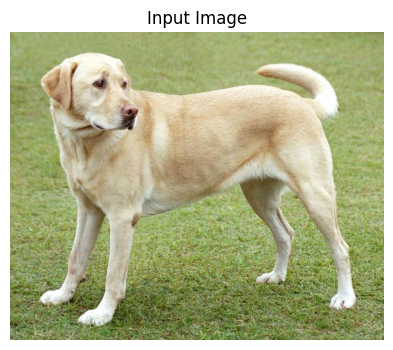

In [14]:
# Load an image from a URL
image_url = "https://upload.wikimedia.org/wikipedia/commons/2/26/YellowLabradorLooking_new.jpg"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

# Display image
plt.figure(figsize=(6, 4))
plt.imshow(image)
plt.axis('off')
plt.title("Input Image")
plt.show()

# Define multiple text prompts
text_prompts = [
    "a photo of a yellow labrador",
    "a photo of a cat",
    "a landscape with mountains",
    "a golden retriever dog"
]

#🔍 **Encode with CLIP**

In [15]:
inputs = processor(text=text_prompts, images=image, return_tensors="pt", padding=True).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    image_embeds = outputs.image_embeds
    text_embeds = outputs.text_embeds


# 📏 **Computing Cosine Similarity Between Embeddings**
Normalize image and text embeddings to unit vectors.

Compute cosine similarity between the image embedding and each text embedding.

Interpret similarity scores to see how well each text matches the image content.

In [16]:
# Normalize the embeddings
image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

# Compute cosine similarity
similarity = (image_embeds @ text_embeds.T).squeeze()

# Display similarities
for i, prompt in enumerate(text_prompts):
    print(f"Similarity with '{prompt}': {similarity[i].item():.4f}")

# Best match
best_idx = similarity.argmax().item()
print(f"\n👉 Best match: '{text_prompts[best_idx]}' with similarity {similarity[best_idx].item():.4f}")


Similarity with 'a photo of a yellow labrador': 0.3156
Similarity with 'a photo of a cat': 0.1918
Similarity with 'a landscape with mountains': 0.1224
Similarity with 'a golden retriever dog': 0.2784

👉 Best match: 'a photo of a yellow labrador' with similarity 0.3156


## 🖼️ Generate Caption from Image


In [17]:
# Load image captioning model
caption_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
caption_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
caption_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

caption_model.to(device)

def generate_caption(image):
    if image.mode != "RGB":
        image = image.convert(mode="RGB")
    pixel_values = caption_processor(images=image, return_tensors="pt").pixel_values.to(device)
    output_ids = caption_model.generate(pixel_values, max_length=16, num_beams=1)
    caption = caption_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption

caption = generate_caption(image)
print("👉 Caption:", caption)


👉 Caption: a dog is standing in the grass with its mouth open 


## 📝 **Summary**

In this task, I explored how **CLIP** generates **joint embeddings** for images and text in a shared semantic space:

- **Encoded** an image and multiple text prompts using a pretrained CLIP model.

- **Computed cosine similarity** between the image and each text to measure their semantic alignment.

- **Interpreted similarity scores** to determine which text best describes the image.
- **Generated a caption** for the image using a Vision-Encoder-Decoder model (`vit-gpt2-image-captioning`).